<a href="https://colab.research.google.com/github/HeshanNavindu-7/Pneumonia-Detection/blob/main/pneumonia_detection_2_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images


100%|██████████| 1.17G/1.17G [00:19<00:00, 65.9MB/s]


**visualizations**

In [4]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/labeled-chest-xray-images/chest_xray"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




test
train


Train Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


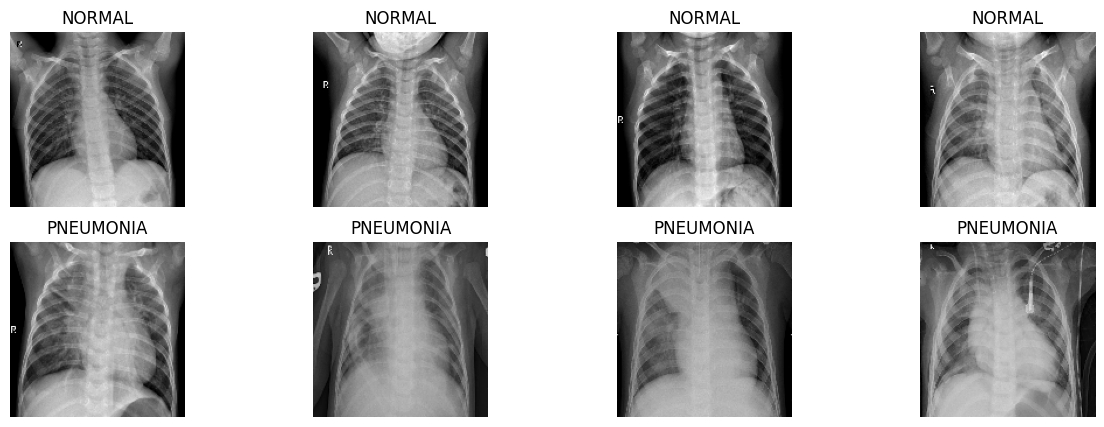

Test Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


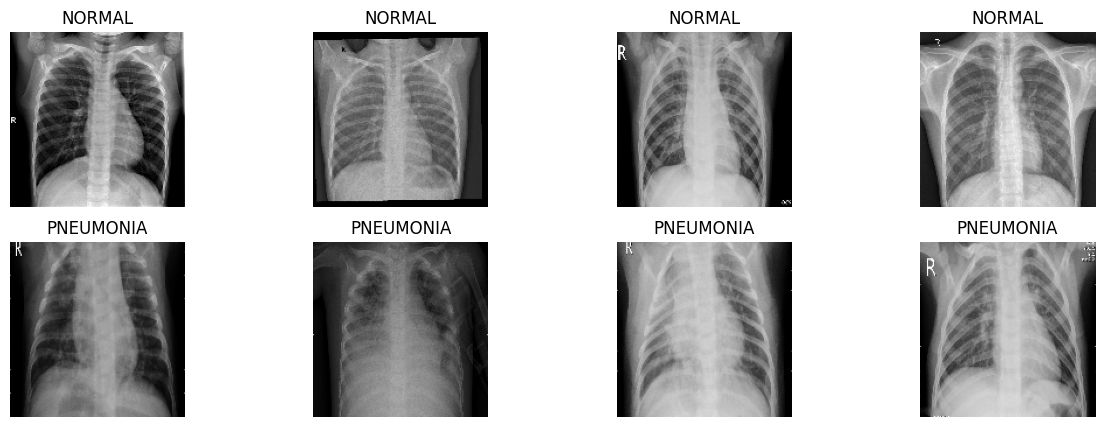

In [5]:
import cv2
import matplotlib.pyplot as plt
import os

# Define subdirectories for train and test data
train_dir = '/content/labeled-chest-xray-images/chest_xray/train'
test_dir = '/content/labeled-chest-xray-images/chest_xray/test'

# Define image size and batch size
target_size = (150, 150)
batch_size = 32

# Define classes
classes = ['NORMAL', 'PNEUMONIA']

# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        print(f"Displaying {num_samples} samples from '{class_name}' class:")

        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize image
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)


#  preprocessing and augmenting

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define preprocessing and data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Ensure validation split for training data
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Use the 'training' subset
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use the 'validation' subset
)

# Generate batches of data for testing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Build DL Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    Dropout(0.25),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

print(model.summary())

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                 

In [20]:
!pip install visualkeras

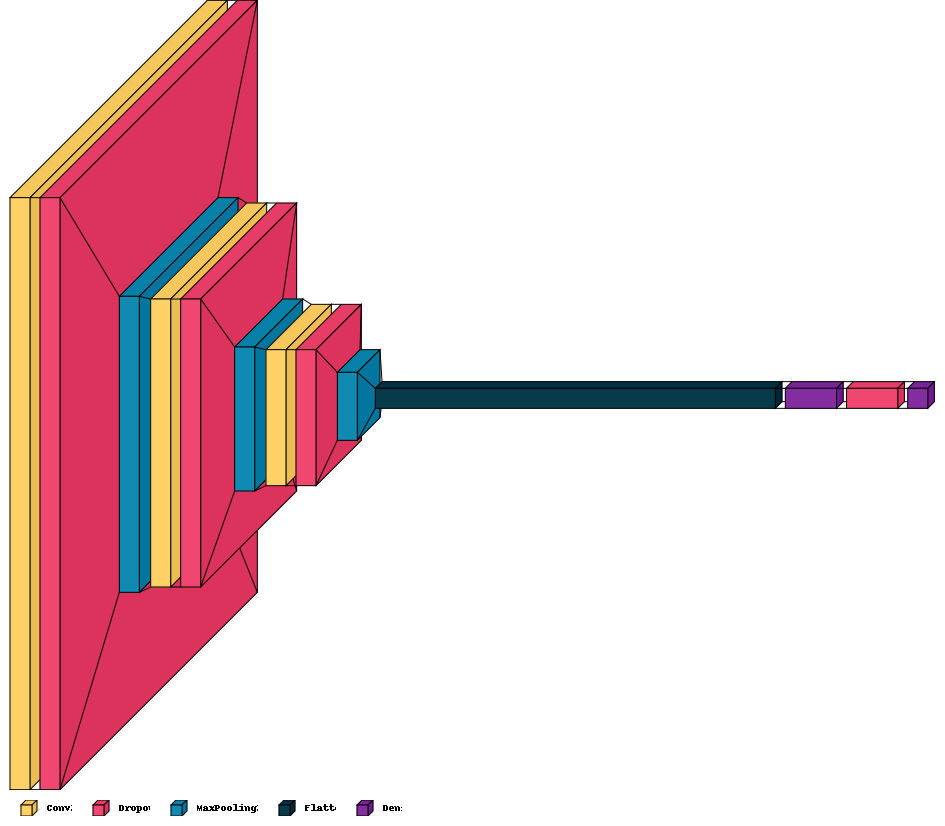

In [21]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [22]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to handle class imbalance
y_true = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_true), y=y_true)
class_weights_dict = dict(enumerate(class_weights))

# Train the model using generators with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights_dict
)


Epoch 1/15
130/130 [==============================] - 368s 3s/step - loss: 0.7740 - accuracy: 0.5933 - val_loss: 0.5400 - val_accuracy: 0.8105
Epoch 2/15
130/130 [==============================] - 358s 3s/step - loss: 0.5313 - accuracy: 0.7420 - val_loss: 0.3899 - val_accuracy: 0.8672
Epoch 3/15
130/130 [==============================] - 361s 3s/step - loss: 0.4911 - accuracy: 0.7742 - val_loss: 0.3987 - val_accuracy: 0.8545
Epoch 4/15
130/130 [==============================] - 355s 3s/step - loss: 0.4012 - accuracy: 0.8250 - val_loss: 0.4426 - val_accuracy: 0.8154
Epoch 5/15
130/130 [==============================] - 337s 3s/step - loss: 0.3757 - accuracy: 0.8303 - val_loss: 0.3299 - val_accuracy: 0.8789
Epoch 6/15
130/130 [==============================] - 355s 3s/step - loss: 0.3422 - accuracy: 0.8527 - val_loss: 0.3083 - val_accuracy: 0.8770
Epoch 7/15
130/130 [==============================] - 340s 3s/step - loss: 0.3260 - accuracy: 0.8558 - val_loss: 0.3063 - val_accuracy: 0.8672

In [23]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


20/20 [==============================] - 22s 1s/step - loss: 0.3085 - accuracy: 0.8702
Test Loss: 0.3085465133190155
Test Accuracy: 0.870192289352417


In [24]:
# Evaluate the model on the test dataset
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_accuracy}')

131/131 [==============================] - 117s 887ms/step - loss: 0.2225 - accuracy: 0.9097
Train Loss: 0.22252200543880463
Train Accuracy: 0.9097205400466919


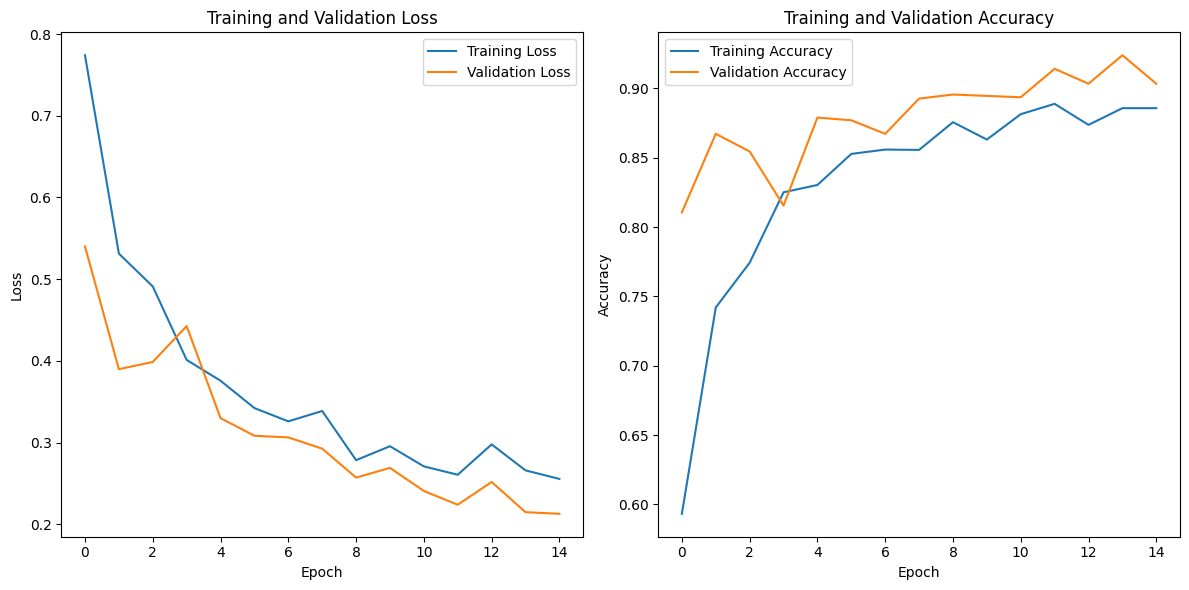

In [25]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [26]:

print("Results")
result = model.evaluate_generator(test_generator, verbose=1)

print("%s%.2f" % ("Loss     : ", result[0]))
print("%s%.2f%s" % ("Accuracy : ", result[1] * 100, "%"))


Results


<ipython-input-26-11f1a34e3d1a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result = model.evaluate_generator(test_generator, verbose=1)


20/20 [==============================] - 15s 727ms/step - loss: 0.3085 - accuracy: 0.8702
Loss     : 0.31
Accuracy : 87.02%


20/20 [==============================] - 12s 578ms/step


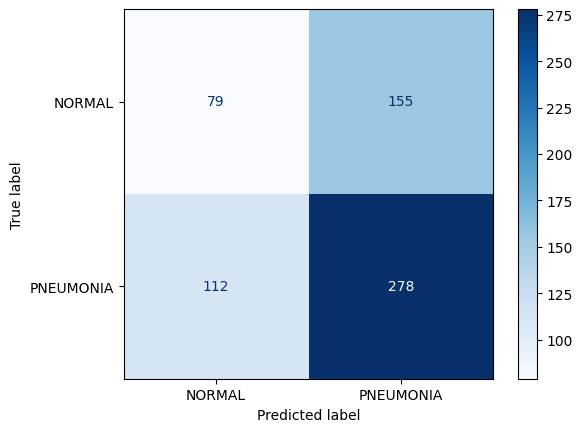

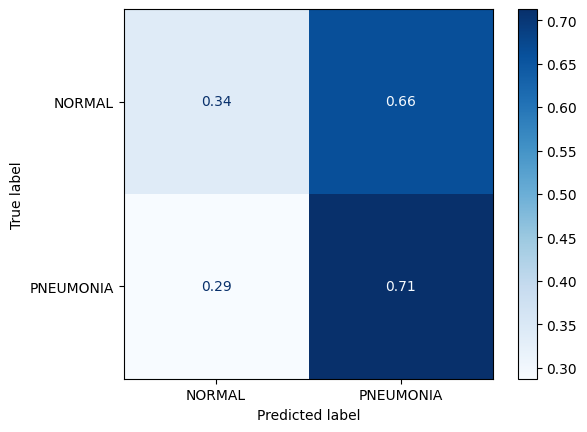

              precision    recall  f1-score   support

      NORMAL       0.41      0.34      0.37       234
   PNEUMONIA       0.64      0.71      0.68       390

    accuracy                           0.57       624
   macro avg       0.53      0.53      0.52       624
weighted avg       0.56      0.57      0.56       624



In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt
# Confusion Matrix and Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.round(y_pred).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image  # Import from tensorflow.keras instead of keras

# Function to preprocess a single image for prediction
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))  # Load image and resize to match model input size
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Function to make predictions on a single image
def predict_single_image(model, image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    # Make prediction
    prediction = model.predict(img_array)
    return prediction

# Function to display prediction result
def display_prediction(prediction):
    if prediction[0][0] > 0.5:
        print("Prediction: PNEUMONIA")
    else:
        print("Prediction: NORMAL")

#  usage:

image_path = '/content/labeled-chest-xray-images/chest_xray/train/NORMAL/NORMAL-1012843-0001.jpeg'  # Example image path
prediction = predict_single_image(model, image_path)
display_prediction(prediction)


1/1 [==============================] - 0s 39ms/step
Prediction: NORMAL


In [ ]:
# Save the trained model
model.save('saved_model')


## Convert to TensorFlow Lite

In [ ]:
import tensorflow as tf

# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]


In [ ]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_new_converter = True  # Use the new converter for better compatibility


In [ ]:
# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
